In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import bioframe
from scipy.stats import fisher_exact
import warnings
warnings.filterwarnings('ignore')

## Overlap between allele-specific peaks

In [2]:
asocr_peaks = pd.DataFrame()

for sample in ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']:
    peaks = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/ATACseq/peaks/{sample}_peaks.canonical.replicated.no_blacklist.bed',
                        sep = '\t', header = None, names = ['seqname', 'start', 'end', 'peak_id'])
    deseq_res = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/ATACseq/asocr/asocr_{sample}.csv', sep = '\s+', header = 0)
    deseq_res['peak_id'] = deseq_res.index
    deseq_res = deseq_res.merge(peaks, on = 'peak_id')

    asocr = deseq_res[(deseq_res['padj'] < 0.05) & (abs(deseq_res['log2FoldChange']) > 1)]
    asocr_peaks = asocr_peaks.append(asocr[['seqname', 'start', 'end', 'peak_id']],  ignore_index=True)

In [3]:
asocr_peaks.columns = ['chrom', 'start', 'end', 'peak_id']
asocr_peaks_merged = bioframe.merge(asocr_peaks, min_dist=0)

In [6]:
np.unique(bioframe.count_overlaps(asocr_peaks_merged, asocr_peaks)['count'], return_counts = True)

(array([1, 2, 3, 4, 5]), array([4411,  612,  120,   22,    2]))

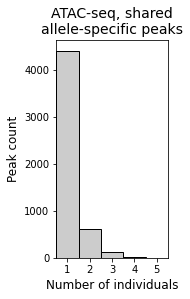

In [4]:
plt.figure(figsize = (2, 4))
plt.title('ATAC-seq, shared\nallele-specific peaks', fontsize = 14)
plt.hist(bioframe.count_overlaps(asocr_peaks_merged, asocr_peaks)['count'], range = (0, 6), bins = 6, color = '#CCCCCC', edgecolor = 'k')
plt.xticks(np.arange(5)+1.5, [1, 2, 3, 4, 5])
plt.xlim((1, 6))
plt.xlabel('Number of individuals', fontsize = 12)
plt.ylabel('Peak count', fontsize = 12)
plt.savefig('/DATA/users/m.magnitov/hap_phen/figures/quantification_shared_atacseq_peaks.pdf', bbox_inches = 'tight')
plt.show()

## Read and prepare caQTL data (Tehranchi et al.)

### caQTLs individual populations

In [2]:
caqtls = []

for population in ['ASW', 'CEU', 'CHB', 'ESN', 'FIN', 'GWD', 'IBS', 'LWK', 'TSI', 'YRI']:
    caqtls_population = pd.read_excel('/DATA/users/m.magnitov/hap_phen/ATACseq/public_data/tehranchi_caqtl_elife-39595-supp1-v1.xlsx', 
                                      sheet_name = population, header = 0)
    caqtls_population['pop'] = [population]*len(caqtls_population)
    caqtls = caqtls + list(caqtls_population.values)
    
caqtls = pd.DataFrame(caqtls)
caqtls.columns = ['chrom', 'position', 'alt', 'ref', 'higher_binding', 'pvalue', 'population']
caqtls['chrom'] = ['chr' + str(x) for x in caqtls['chrom'].values]
caqtls['start'] = caqtls['position']
caqtls['end'] = caqtls['position']
caqtls = caqtls[['chrom', 'start', 'end', 'ref', 'alt', 'higher_binding', 'pvalue', 'population']]
caqtls.to_csv('/DATA/users/m.magnitov/hap_phen/ATACseq/public_data/tehranchi_caqtl.bed', sep = '\t', header = 0, index = 0)
caqtls.head()

,chrom,start,end,ref,alt,higher_binding,pvalue,population
0,chr10,104952499,104952499,C,T,C,0.000000e+00,ASW
1,chr11,189987,189987,G,A,G,0.000000e+00,ASW
2,chr11,190010,190010,G,A,G,0.000000e+00,ASW
3,chr2,131029958,131029958,A,G,G,0.000000e+00,ASW
4,chr5,148737409,148737409,G,C,G,1.762366e-259,ASW


CrossMap.py bed /DATA/users/m.magnitov/genomes/hg19ToHg38.over.chain /DATA/users/m.magnitov/hap_phen/ATACseq/public_data/tehranchi_caqtl.bed /DATA/users/m.magnitov/hap_phen/ATACseq/public_data/tehranchi_caqtl.crossmap_hg38.bed

In [2]:
caqtls = pd.read_csv('/DATA/users/m.magnitov/hap_phen/ATACseq/public_data/tehranchi_caqtl.crossmap_hg38.bed', 
                     sep = '\t', header = None)
caqtls.columns = ['chrom', 'start', 'end', 'ref', 'alt', 'higher_binding', 'pvalue', 'population']


canonical_chromosomes = ['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19'
                         'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9']
caqtls = caqtls[caqtls['chrom'].isin(canonical_chromosomes)]

caqtls.sort_values(['chrom', 'start'])

,chrom,start,end,ref,alt,higher_binding,pvalue,population
572,chr1,13116,13116,T,G,G,4.996986e-36,ASW
30154,chr1,13116,13116,T,G,G,1.439626e-15,CEU
67287,chr1,13116,13116,T,G,G,5.889581e-27,ESN
97346,chr1,13116,13116,T,G,G,3.404907e-14,FIN
122836,chr1,13116,13116,T,G,T,1.404662e-07,GWD
...,...,...,...,...,...,...,...,...
60762,chr9,138165718,138165718,C,G,G,1.015815e-04,CHB
53914,chr9,138175504,138175504,C,T,C,6.298289e-07,CHB
83199,chr9,138175504,138175504,C,T,C,3.638925e-05,ESN
174548,chr9,138175831,138175831,T,C,C,4.954972e-08,LWK


### caQTLs shared across populations

In [4]:
caqtls_shared = pd.read_table('/DATA/users/m.magnitov/hap_phen/ATACseq/public_data/tehranchi_shared_caqtl_elife-39595-supp2-v1.txt', 
                              header = 0)
caqtls_shared['chr'] = ['chr' + str(x) for x in caqtls_shared['chr'].values]
caqtls_shared['start'] = caqtls_shared['position']
caqtls_shared['end'] = caqtls_shared['position']
caqtls_shared = caqtls_shared[caqtls_shared['number of pops with p<0.005'] != 1]
caqtls_shared = caqtls_shared[['chr', 'start', 'end', 'pops with p<0.005', 'number of pops with p<0.005']]
caqtls_shared.to_csv('/DATA/users/m.magnitov/hap_phen/ATACseq/public_data/tehranchi_shared_caqtl.bed', sep = '\t', header = 0, index = 0)

CrossMap.py bed /DATA/users/m.magnitov/genomes/hg19ToHg38.over.chain /DATA/users/m.magnitov/hap_phen/ATACseq/public_data/tehranchi_shared_caqtl.bed /DATA/users/m.magnitov/hap_phen/ATACseq/public_data/tehranchi_shared_caqtl.crossmap_hg38.bed

In [3]:
shared_caqtls = pd.read_csv('/DATA/users/m.magnitov/hap_phen/ATACseq/public_data/tehranchi_shared_caqtl.crossmap_hg38.bed', sep = '\t', header = None)
shared_caqtls.columns = ['chrom', 'start', 'end', 'pops_p<0.005', 'number_p<0.005']

canonical_chromosomes = ['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19'
                         'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9']
shared_caqtls = shared_caqtls[shared_caqtls['chrom'].isin(canonical_chromosomes)]

shared_caqtls.sort_values(['chrom', 'start']).drop_duplicates()

,chrom,start,end,pops_p<0.005,number_p<0.005
0,chr1,13116,13116,"ASW,CEU,ESN,FIN,GWD,IBS,LWK,TSI,YRI",9
1,chr1,13118,13118,"ASW,CEU,ESN,FIN,IBS,LWK,TSI,YRI",8
2,chr1,16949,16949,"ASW,CEU,GWD,IBS,YRI",5
3,chr1,586198,586198,"GWD,LWK,YRI",3
4,chr1,827105,827105,"ASW,CEU,CHB,ESN,FIN,GWD,IBS,LWK,TSI,YRI",10
...,...,...,...,...,...
23633,chr9,138053638,138053638,"ASW,ESN,GWD,LWK",4
23634,chr9,138141161,138141161,"CEU,LWK,TSI",3
23635,chr9,138141164,138141164,"CEU,GWD,LWK,TSI",4
23636,chr9,138144123,138144123,"ASW,ESN,IBS,YRI",4


## Overlap peaks with caQTLs

In [4]:
def read_variants(sample):
    variants = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/personal_genomes/{sample}/{sample}.phased.het.bed', 
                           sep = '\t', header = None)
    variants[11] = [int(x.split('|')[0]) for x in variants[10].values]
    variants[12] = [int(x.split('|')[1].split(':')[0]) for x in variants[10].values]
    variants = variants[[0, 2, 2, 5, 6, 11, 12]]
    variants.columns = ['chrom', 'start', 'end', 'ref', 'alt', 'allele_ref', 'allele_alt']
    return(variants)

def read_asocr_peaks(sample):
    asocr_peaks = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/ATACseq/asocr/{sample}_allele_specific.bed', sep = '\t', header = None)
    asocr_peaks.columns = ['chrom', 'start', 'end', 'peak_id', 'baseMean', 'log2FoldChange', 'FDR']
    asocr_peaks = asocr_peaks[asocr_peaks['chrom'] != 'chrX']
    return(asocr_peaks[['chrom', 'start', 'end', 'peak_id', 'log2FoldChange']])

def read_balanced_peaks(sample):
    balanced_peaks = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/ATACseq/asocr/{sample}_balanced.bed', sep = '\t', header = None)
    balanced_peaks.columns = ['chrom', 'start', 'end', 'peak_id', 'baseMean', 'log2FoldChange', 'FDR']
    balanced_peaks = balanced_peaks[balanced_peaks['chrom'] != 'chrX']
    return(balanced_peaks[['chrom', 'start', 'end', 'peak_id', 'log2FoldChange']])
    
def get_variants_for_peaks(phased_variants, peaks):
    phased_variants_overlap_peaks = bioframe.overlap(phased_variants, peaks, suffixes = ('', '_peak'))
    phased_variants_overlap_peaks = phased_variants_overlap_peaks.dropna()

    putative_non_overlaps = peaks[~peaks['peak_id'].isin(phased_variants_overlap_peaks['peak_id_peak'])]['peak_id'].values
    if len(putative_non_overlaps) != 0:
        peaks_non_overlaps = peaks[peaks['peak_id'].isin(putative_non_overlaps)]

        phased_variants_overlap_non_overlaps = bioframe.closest(peaks_non_overlaps, phased_variants, suffixes = ('_peak', ''))
        sort_order = list(phased_variants_overlap_non_overlaps.columns[5:]) + list(phased_variants_overlap_non_overlaps.columns[:5])
        phased_variants_overlap_non_overlaps = phased_variants_overlap_non_overlaps[sort_order]
        phased_variants_overlap_non_overlaps = phased_variants_overlap_non_overlaps.drop('distance', axis = 1)

    phased_variants_overlap_peaks = pd.concat([phased_variants_overlap_peaks, phased_variants_overlap_non_overlaps], ignore_index = True)
    phased_variants_overlap_peaks = phased_variants_overlap_peaks.sort_values(['chrom', 'start'])
    phased_variants_overlap_peaks.index = np.arange(len(phased_variants_overlap_peaks))
    return(phased_variants_overlap_peaks)

### Quantifications per peak

In [5]:
def convert_pval(pval):
    if pval < 0.0001:
        return('****')
    elif pval < 0.001:
        return('***')
    elif pval < 0.01:
        return('**')
    elif pval < 0.05:
        return('*')
    else:
        return('NS')

In [6]:
## Counts per peak
fractions_of_caqtls = []

for sample in ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464']:
    phased_variants = read_variants(sample)
    asocr_peaks = read_asocr_peaks(sample)
    balanced_peaks = read_balanced_peaks(sample)
    variants_in_asocr_peaks = get_variants_for_peaks(phased_variants, asocr_peaks)
    variants_in_balanced_peaks = get_variants_for_peaks(phased_variants, balanced_peaks)
    
    # Within individual population (EUR)
    for population in ['CEU', 'FIN', 'IBS', 'TSI']:        
        caqtl_overlap_asocr = len(np.unique(variants_in_asocr_peaks.merge(caqtls[caqtls['population'] == population], 
                                                                          on = ['chrom', 'start', 'end', 'ref', 'alt'])['peak_id_peak']))
        fractions_of_caqtls.append([sample, 'asocr', 'EUR', population, 
                                    caqtl_overlap_asocr/len(np.unique(variants_in_asocr_peaks['peak_id_peak']))])
        
        caqtl_overlap_balanced = len(np.unique(variants_in_balanced_peaks.merge(caqtls[caqtls['population'] == population], 
                                                                                on = ['chrom', 'start', 'end', 'ref', 'alt'])['peak_id_peak']))
        fractions_of_caqtls.append([sample, 'balanced', 'EUR', population, 
                                    caqtl_overlap_balanced/len(np.unique(variants_in_balanced_peaks['peak_id_peak']))])
    
    # Within individual population (EAS)
    for population in ['CHB']:        
        caqtl_overlap_asocr = len(np.unique(variants_in_asocr_peaks.merge(caqtls[caqtls['population'] == population], 
                                                                          on = ['chrom', 'start', 'end', 'ref', 'alt'])['peak_id_peak']))
        fractions_of_caqtls.append([sample, 'asocr', 'EAS', population, 
                                    caqtl_overlap_asocr/len(np.unique(variants_in_asocr_peaks['peak_id_peak']))])
        
        caqtl_overlap_balanced = len(np.unique(variants_in_balanced_peaks.merge(caqtls[caqtls['population'] == population], 
                                                                                on = ['chrom', 'start', 'end', 'ref', 'alt'])['peak_id_peak']))
        fractions_of_caqtls.append([sample, 'balanced', 'EAS', population, 
                                    caqtl_overlap_balanced/len(np.unique(variants_in_balanced_peaks['peak_id_peak']))])

    # Within individual population (AFR)
    for population in ['ASW', 'ESN', 'GWD', 'LWK', 'YRI']:
        caqtl_overlap_asocr = len(np.unique(variants_in_asocr_peaks.merge(caqtls[caqtls['population'] == population], 
                                                                          on = ['chrom', 'start', 'end', 'ref', 'alt'])['peak_id_peak']))
        fractions_of_caqtls.append([sample, 'asocr', 'AFR', population, 
                                    caqtl_overlap_asocr/len(np.unique(variants_in_asocr_peaks['peak_id_peak']))])
        
        caqtl_overlap_balanced = len(np.unique(variants_in_balanced_peaks.merge(caqtls[caqtls['population'] == population], 
                                                                                on = ['chrom', 'start', 'end', 'ref', 'alt'])['peak_id_peak']))
        fractions_of_caqtls.append([sample, 'balanced', 'AFR', population, 
                                    caqtl_overlap_balanced/len(np.unique(variants_in_balanced_peaks['peak_id_peak']))])
    
    # Shared across populations
    shared_caqtl_overlap_asocr = len(np.unique(variants_in_asocr_peaks.merge(shared_caqtls, on = ['chrom', 'start', 'end'])['peak_id_peak']))
    fractions_of_caqtls.append([sample, 'asocr', 'shared', 'shared', shared_caqtl_overlap_asocr/len(np.unique(variants_in_asocr_peaks['peak_id_peak']))])

    shared_caqtl_overlap_balanced = len(np.unique(variants_in_balanced_peaks.merge(shared_caqtls, on = ['chrom', 'start', 'end'])['peak_id_peak']))
    fractions_of_caqtls.append([sample, 'balanced', 'shared', 'shared', shared_caqtl_overlap_balanced/len(np.unique(variants_in_balanced_peaks['peak_id_peak']))])
    
    odds, pval = fisher_exact([[shared_caqtl_overlap_asocr, 
                                shared_caqtl_overlap_balanced],
                               [len(np.unique(variants_in_asocr_peaks['peak_id_peak']))-shared_caqtl_overlap_asocr,
                                len(np.unique(variants_in_balanced_peaks['peak_id_peak']))-shared_caqtl_overlap_balanced]], alternative = 'two-sided')
    print(sample + ':')
    print('\tASOCR:', shared_caqtl_overlap_asocr, '/', len(np.unique(variants_in_asocr_peaks['peak_id_peak'])))
    print('\tBalanced:', shared_caqtl_overlap_balanced, '/', len(np.unique(variants_in_balanced_peaks['peak_id_peak'])))
    print('\tOR =', round(odds, 1), ', p-value =', pval, convert_pval(pval))
    
fractions_of_caqtls_peaks = pd.DataFrame(fractions_of_caqtls)
fractions_of_caqtls_peaks.columns = ['sample', 'peak_type', 'superpopulation', 'population', 'fraction']
fractions_of_caqtls_peaks

NA12878:
	ASOCR: 392 / 883
	Balanced: 3060 / 15811
	OR = 3.3 , p-value = 4.3238118173358805e-60 ****
NA18983:
	ASOCR: 544 / 1397
	Balanced: 3084 / 18762
	OR = 3.2 , p-value = 4.450255533905161e-82 ****
HG01241:
	ASOCR: 250 / 560
	Balanced: 3569 / 18405
	OR = 3.4 , p-value = 1.9058280773925945e-40 ****
HG02601:
	ASOCR: 321 / 681
	Balanced: 2965 / 14089
	OR = 3.3 , p-value = 7.630437309877956e-49 ****
HG03464:
	ASOCR: 624 / 1874
	Balanced: 3728 / 25300
	OR = 2.9 , p-value = 3.0888660366907106e-82 ****


,sample,peak_type,superpopulation,population,fraction
0,NA12878,asocr,EUR,CEU,0.297848
1,NA12878,balanced,EUR,CEU,0.089748
2,NA12878,asocr,EUR,FIN,0.297848
3,NA12878,balanced,EUR,FIN,0.089937
4,NA12878,asocr,EUR,IBS,0.338618
...,...,...,...,...,...
105,HG03464,balanced,AFR,LWK,0.095178
106,HG03464,asocr,AFR,YRI,0.269477
107,HG03464,balanced,AFR,YRI,0.099644
108,HG03464,asocr,shared,shared,0.332978


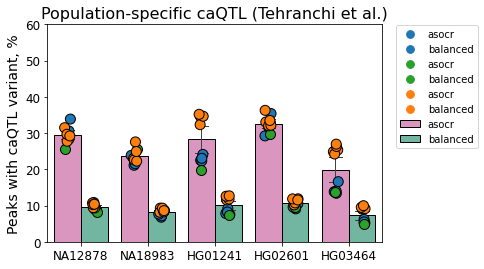

In [13]:
colors = {'EUR': 'C0', 'EAS': 'C2', 'AMR': 'C3', 'SAS': 'C4', 'AFR': 'C1'}

plt.figure(figsize = (6, 4))
plt.title('Population-specific caQTL (Tehranchi et al.)', fontsize = 16)
sns.barplot(data = fractions_of_caqtls_peaks[fractions_of_caqtls_peaks['superpopulation'] != 'shared'], 
            x = 'sample', y = 'fraction', hue = 'peak_type',
            edgecolor = 'k', palette = ['#E68AC3', '#66C2A5'], capsize = 0.2, errwidth = 1)

for superpopulation in ['EUR', 'EAS', 'AFR']:
    sns.stripplot(data = fractions_of_caqtls_peaks[fractions_of_caqtls_peaks['superpopulation'] == superpopulation], 
                  x = 'sample', y = 'fraction', hue = 'peak_type', dodge = True,
                  edgecolor = 'k', linewidth = 1, palette = [colors[superpopulation]], size = 10)
    
plt.xlabel('')
plt.xticks([0, 1, 2, 3, 4], ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464'], fontsize = 12)
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6], ['0', '10', '20', '30', '40', '50', '60'], fontsize = 12)
plt.ylabel('Peaks with caQTL variant, %', fontsize = 14)
plt.ylim((0, 0.6))
plt.legend(bbox_to_anchor = (1.3, 1.02))
plt.savefig('/DATA/users/m.magnitov/hap_phen/figures/quantification_overlap_caQTLs_pop_specific.pdf', bbox_inches = 'tight')
plt.show()

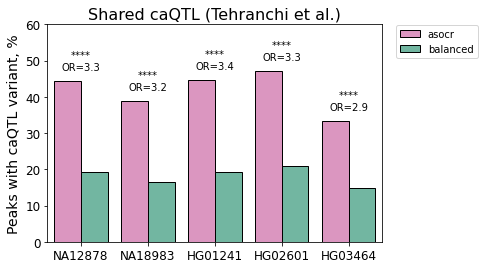

In [14]:
plt.figure(figsize = (6, 4))
plt.title('Shared caQTL (Tehranchi et al.)', fontsize = 16)
sns.barplot(data = fractions_of_caqtls_peaks[fractions_of_caqtls_peaks['superpopulation'] == 'shared'], 
            x = 'sample', y = 'fraction', hue = 'peak_type',
            edgecolor = 'k', palette = ['#E68AC3', '#66C2A5'], capsize = 0.2, errwidth = 1)

for (ann, x, y) in zip([3.3, 3.2, 3.4, 3.3, 2.9], np.arange(5), 
                       fractions_of_caqtls_peaks[(fractions_of_caqtls_peaks['superpopulation'] == 'shared') & (fractions_of_caqtls_peaks['peak_type'] == 'asocr')]['fraction']):
    plt.text(x, y+0.03, s = '****\nOR=' + str(ann), ha = 'center')


plt.xlabel('')
plt.xticks([0, 1, 2, 3, 4], ['NA12878', 'NA18983', 'HG01241', 'HG02601', 'HG03464'], fontsize = 12)
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6], ['0', '10', '20', '30', '40', '50', '60'], fontsize = 12)
plt.ylabel('Peaks with caQTL variant, %', fontsize = 14)
plt.ylim((0, 0.6))
plt.legend(bbox_to_anchor = (1.3, 1.02))
plt.savefig('/DATA/users/m.magnitov/hap_phen/figures/quantification_overlap_caQTLs_shared.pdf', bbox_inches = 'tight')
plt.show()